# Gravitational Wave Parameter-Estimation Workshop

## Tutorial: Parameter estimation for a GW150914-like injection in simulated data

(Note, this tutorial and the open-data tutorial (tutorial A) are based on the [GWOSC ODW #3 tutorial 2.4](https://github.com/gw-odw/odw-2020). You may wish to browse that repository for similar notebooks covering a range of gravitational-wave data analysis subjects). 

This example estimates the non-spinning parameters of an injected binary black hole system using
commonly used prior distributions. This will take about 40 minutes to run.
   
More examples at https://lscsoft.docs.ligo.org/bilby/examples.html

##  Installation  (execute only if running on a cloud platform!)

In [1]:
# -- Use the following line in Google Colab
#! pip install -q 'lalsuite' 'bilby' 'gwpy' 'nestle'
#! pip install -q 'nestle'

**Important:** With Google Colab, you may need to restart the runtime after running the cell above.

## Initialization

We begin by importing some commonly used functions

In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt

import bilby
from bilby.core.prior import Uniform
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters
%matplotlib inline

## Bilby version

In [2]:
print(bilby.__version__)

1.0.1: release


## Creating fake data
In this notebook, we'll analyse GW150914-like injection. Our first task is to create some data!

Set up a random seed for result reproducibility.  This is optional!

In [2]:
np.random.seed(1234)

We now need to specify the parameters of our injection. You can set this up as a python dictionary

In [3]:
injection_parameters = dict(
    mass_1=36., mass_2=29., a_1=0.4, a_2=0.3, tilt_1=0.5, tilt_2=1.0,
    phi_12=1.7, phi_jl=0.3, luminosity_distance=4000., theta_jn=0.4, psi=2.659,
    phase=1.3, geocent_time=1126259642.413, ra=1.375, dec=-1.2108)

We also need to set up some additional arguments such as what waveform approximant to use and what the minimum frequencies for analysis are. This can again be set up as a python dictionary. While the duration and sampling frequenciy can be set up as variables.

In [5]:
waveform_arguments = dict(waveform_approximant='IMRPhenomPv2',
                          reference_frequency=50., minimum_frequency=20., catch_waveform_errors=True)
duration = 4.
sampling_frequency = 1024.

We will now set up a bilby waveform generator. This wraps up some of the jobs of converting between parameters etc

In [8]:
np.shape(np.array([1,2,3]))

(3,)

In [9]:
from bilby.gw.source import lal_binary_black_hole

def my_function(frequency_array, mass_1, mass_2, luminosity_distance, a_1, tilt_1,
                phi_12, a_2, tilt_2, phi_jl, theta_jn, phase, **kwargs):
    print(np.shape(frequency_array))
    return lal_binary_black_hole(frequency_array, mass_1, mass_2, luminosity_distance,
                                 a_1, tilt_1, phi_12, a_2, tilt_2, phi_jl, theta_jn, phase, **kwargs)

In [5]:
import time 

fff = np.arange(0,100,1)
t0 = time.time()
zz = bilby.gw.source.lal_binary_black_hole(frequency_array=fff,mass_1=36., mass_2=29., a_1=0.4, a_2=0.3, tilt_1=0.5, tilt_2=1.0,
    phi_12=1.7, phi_jl=0.3, luminosity_distance=4000., theta_jn=0.4, psi=2.659,
    phase=1.3, geocent_time=1126259642.413, ra=1.375, dec=-1.2108)
t1 = time.time()
print('Execution took {:.4f}'.format(t1 - t0))

Execution took 0.0480


In [10]:
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=my_function,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments)

08:07 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: __main__.my_function
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


We now set up the bilby interferometers and inject data

In [11]:
ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=injection_parameters['geocent_time'] - 3)
injection = ifos.inject_signal(
    waveform_generator=waveform_generator,
    parameters=injection_parameters)

/home/hemantakumar.phurailatpam/anaconda3/envs/bilby/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
08:08 bilby INFO    : Injected signal in H1:
08:08 bilby INFO    :   optimal SNR = 5.89
08:08 bilby INFO    :   matched filter SNR = 6.27+0.70j
08:08 bilby INFO    :   mass_1 = 36.0
08:08 bilby INFO    :   mass_2 = 29.0
08:08 bilby INFO    :   a_1 = 0.4
08:08 bilby INFO    :   a_2 = 0.3
08:08 bilby INFO    :   tilt_1 = 0.5
08:08 bilby INFO    :   tilt_2 = 1.0
08:08 bilby INFO    :   phi_12 = 1.7
08:08 bilby INFO    :   phi_jl = 0.3
08:08 bilby INFO    :   luminosity_distance = 4000.0
08:08 bilby INFO    :   theta_jn = 0.4
08:08 bilby INFO    :   psi = 2.659
08:08 bilby INFO    :   phase = 1.3
08:08 bilby INFO    :   geocent_time = 1126259642.413
08:08 bilby INFO    :   ra = 1.375
08:08 bilby INFO    :   dec = -1.2108
08:

(2049,)


### Looking at the data
Okay, we have spent a bit of time now initializing things. Let's check that everything makes sense. To do this, we'll plot our analysis data alongwise the amplitude spectral density (ASD); this is just the square root of the PSD and has the right units to be comparable to the frequency-domain strain data. We also add the "injection", here we plot the absolute value of the (complex) plus polarization.

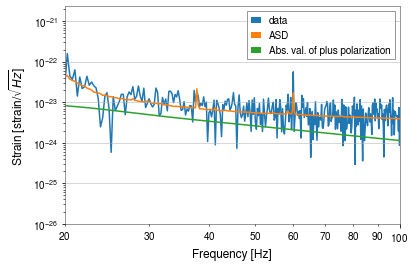

In [12]:
H1 = ifos[0]
H1_injection = injection[0]

fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]),
          label="data")
ax.loglog(H1.frequency_array[idxs],
          H1.amplitude_spectral_density_array[idxs],
          label="ASD")
ax.loglog(H1.frequency_array[idxs],
          np.abs(H1_injection["plus"][idxs]),
          label="Abs. val. of plus polarization")

'''L1 = ifos[1]
L1_injection = injection[1]

ax.loglog(L1.frequency_array[idxs]+5,
          L1.amplitude_spectral_density_array[idxs],
          label="ASD")'''

ax.set_xlim(20.,100.)
ax.set_ylim(1e-26,2.327737159425905e-21)


ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
ax.legend()
plt.show()

In [13]:
def get_injection_snr(injection_parameters):
    duration = 4.
    sampling_frequency = 2048.
    np.random.seed(88170235)
    waveform_generator = bilby.gw.WaveformGenerator(
        duration=duration,
        sampling_frequency=sampling_frequency,
        frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
        parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
        waveform_arguments=dict(
            waveform_approximant='IMRPhenomPv2',
            reference_frequency=50., minimum_frequency=20.
        )
    )
    # Set up interferometers.
    ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
    ifos.set_strain_data_from_power_spectral_densities(
        sampling_frequency=sampling_frequency,
        duration=duration,
        start_time=injection_parameters['geocent_time'] - 2
    )
    ifos.inject_signal(
        waveform_generator=waveform_generator,
        parameters=injection_parameters
    )
    snrs = [ifo.meta_data["optimal_SNR"] for ifo in ifos]
    return np.sqrt(np.sum([i ** 2 for i in snrs]))

In [14]:
snrs = [ifo.meta_data["optimal_SNR"] for ifo in ifos]

In [15]:
np.sqrt(np.sum([i ** 2 for i in snrs]))

7.57607938923325

## Low dimensional analysis

As in the open-data tutorial, we'll do a low-dimensional analysis.

### Create a prior

Here, we create a prior fixing everything except the chirp mass, mass ratio and geocent_time parameters to fixed values. The first two we described above. The geocent_time is the time at which it merges.

In [16]:
prior = bilby.core.prior.PriorDict()
prior['chirp_mass'] = Uniform(name='chirp_mass', minimum=27.0,maximum=32.5)
prior['mass_ratio'] = Uniform(name='mass_ratio', minimum=0.5, maximum=1)
# We fix the rest of the parameters to their injected values
for key in ['a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'psi', 'ra',
            'dec','luminosity_distance', 'theta_jn', 'phase', 'geocent_time']:
    prior[key] = injection_parameters[key]

## Create a likelihood

For Bayesian inference, we need to evaluate the likelihood. In Bilby, we create a likelihood object. This is the communication interface between the sampling part of Bilby and the data. Explicitly, when Bilby is sampling it only uses the `parameters` and `log_likelihood()` of the likelihood object. This means the likelihood can be arbitrarily complicated and the sampling part of Bilby won't mind a bit!

Let's create a `GravitationalWaveTransient`, a special inbuilt method carefully designed to wrap up evaluating the likelihood of a waveform model in some data.

In [17]:
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=waveform_generator, priors=prior,
    time_marginalization=False, phase_marginalization=False, distance_marginalization=False)


This will print a warning about the `start_time`, it is safe to ignore this.

Here, we do not use any marginalization (we fixed these parameters to the injection values in the prior)

### Run the analysis

Now that the prior is set-up and the likelihood is set-up (with the data and the signal mode), we can run the sampler to get the posterior result. This function takes the likelihood and prior along with some options for how to do the sampling and how to save the data.

In [18]:
result_short = bilby.run_sampler(
    likelihood, prior, sampler='dynesty', outdir='short', label="GW150914",
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
    nlive=500, dlogz=3,  # <- Arguments are used to make things fast - not recommended for general use
    clean=True
)

08:08 bilby INFO    : Running for label 'GW150914', output will be saved to 'short'
08:08 bilby INFO    : Using lal version 7.1.2
08:08 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v6.82;Id: cf792129c2473f42ce6c6ee21d8234254cefd337;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
08:08 bilby INFO    : Using lalsimulation version 2.5.1
08:08 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v6.82;Id: cf792129c2473f42ce6c6ee21d8234254cefd337;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
08:08 bilby INFO    : Search parameters:
08:08 bilby INFO    :   chirp_mass = Uniform(minimum=27.0, maximum=32.5, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
08:08 bilby INFO    :   mass_ratio = Uniform(minimum=0.5, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)
08:08 bilby INFO    :   a_1 = 0.4
08:08 bilby INFO    :   a_2 = 0.3
08:08 bilby INFO  

(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)


08:08 bilby INFO    : Single likelihood evaluation took 3.231e-03 s


(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
0it [00:00, ?it/s]

08:08 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f475735e150>>, 'dlogz': 3, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
08:08 bilby INFO    : Checkpoint every check_point_delta_t = 600s
08:08 bilby INFO    : Using dynesty version 1.0.1
08:08 bilby INFO    : Generating initial points from the prior

(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)


08:08 bilby INFO    : Using the bilby-implemented rwalk sample method with ACT estimated walks


(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1it [00:02,  2.71s/it, bound:0 nc:  1 ncall:5.0e+02 eff:0.2% logz-ratio=-94.75+/-0.17 dlogz:inf>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
31it [00:02,  1.90s/it, bound:0 nc:  2 ncall:5.3e+02 eff:5.8% logz-ratio=-78.91+/-0.16 dlogz:117.456>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
61it [00:02,  1.33s/it, bound:0 nc:  1 ncall:5.6e+02 eff:10.8% logz-ratio=-64.24+/-0.12 dlogz:100.787>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)

(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
465it [00:05, 106.27it/s, bound:0 nc:  9 ncall:1.2e+03 eff:37.9% logz-ratio=-12.00+/-0.12 dlogz:47.706>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
479it [00:05, 112.74it/s, bound:0 nc:  5 ncall:1.3e+03 eff:38.2% logz-ratio=-10.91+/-0.12 dlogz:46.578>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
492it [00:05, 97.10it/s, bound:0 nc:  1 ncall:1.3e+03 eff:37.8% logz-ratio=-10.15+/-0.12 dlogz:45.770>3] (2049,)
(2049,)
(2049,)
(2049

(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
699it [00:08, 69.68it/s, bound:0 nc:  1 ncall:2.0e+03 eff:35.5% logz-ratio=-2.40+/-0.11 dlogz:37.578>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
707it [00:08, 69.79it/s, bound:0 nc:  5 ncall:2.0e+03 eff:35.3% logz-ratio=-2.24+/-0.11 dlogz:37.405>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
717it [00:08, 76.22it/s, bound:0 nc:  7 ncall:2.0e+03 eff:35.2% logz-ratio=-2.03+/-0.11 dlogz:37.175>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(20

867it [00:10, 51.28it/s, bound:0 nc:  7 ncall:2.7e+03 eff:32.0% logz-ratio=3.51+/-0.12 dlogz:31.364>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
876it [00:11, 58.85it/s, bound:0 nc:  1 ncall:2.7e+03 eff:31.9% logz-ratio=4.11+/-0.13 dlogz:30.762>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
883it [00:11, 49.80it/s, bound:0 nc: 16 ncall:2.8e+03 eff:31.6% logz-ratio=4.57+/-0.13 dlogz:30.282>3](2049,)
(2049,)
(2049,

(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
994it [00:13, 34.53it/s, bound:0 nc: 31 ncall:3.5e+03 eff:28.2% logz-ratio=10.04+/-0.13 dlogz:24.579>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
998it [00:13, 34.77it/s, bound:0 nc:  2 ncall:3.5e+03 eff:28.1% logz-ratio=10.23+/-0.13 dlogz:24.379>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1002it [00:14, 36.04it/s, bound:0 nc:  1 ncall:3.6e+03 eff:28.0% logz-ratio=10.45+/-0.13 d

(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1077it [00:16, 31.66it/s, bound:0 nc: 14 ncall:4.3e+03 eff:25.1% logz-ratio=13.99+/-0.13 dlogz:20.498>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1081it [00:16, 30.15it/s, bound:0 nc: 30 ncall:4.3e+03 eff:24.9% logz-ratio=14.16+/-0.13 dlogz:20.318>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1085it [00:16, 31.27it/s, bound:0 nc:  8 ncall:4.4e+03 e

(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1157it [00:19, 32.31it/s, bound:0 nc: 13 ncall:5.1e+03 eff:22.9% logz-ratio=16.77+/-0.13 dlogz:17.542>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1161it [00:19, 33.85it/s, bound:0 nc: 22 ncall:5.1e+03 eff:22.8% logz-ratio=16.89+/-0.13 dlogz:17.416>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1165it [00:19, 30.18it/s, bound:0 nc:  5 ncall:5.1e+03 eff:22.7% logz-ratio=17.01+/-0.13 dlogz:17.293>3](2049,)
(2049,)
(2049,)


(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1229it [00:21, 21.97it/s, bound:0 nc:  5 ncall:5.9e+03 eff:20.9% logz-ratio=18.69+/-0.13 dlogz:15.476>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1232it [00:22, 18.79it/s, bound:0 nc: 25 ncall:5.9e+03 eff:20.7% logz-ratio=18.77+/-0.13 dlogz:15.392>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)


(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1310it [00:24, 20.41it/s, bound:0 nc: 19 ncall:6.7e+03 eff:19.5% logz-ratio=20.78+/-0.13 dlogz:13.230>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)


1356it [00:27, 14.29it/s, bound:0 nc: 14 ncall:7.5e+03 eff:18.1% logz-ratio=21.78+/-0.13 dlogz:12.132>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1358it [00:27, 14.17it/s, bound:0 nc:  5 ncall:7.5e+03 eff:18.1% logz-ratio=21.82+/-0.13 dlogz:12.086>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1361it [00:27, 16.73it/s, bound:0 nc: 10 ncall:7.5e+03 eff:18.0% logz-ratio=21.88+/-0.13 dlogz:12.020>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)


(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1422it [00:30, 18.99it/s, bound:0 nc: 24 ncall:8.3e+03 eff:17.1% logz-ratio=22.99+/-0.13 dlogz:10.787>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1425it [00:30, 18.28it/s, bound:0 nc: 19 ncall:8.4e+03 eff:17.1% logz-ratio=23.0

(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1473it [00:33, 13.84it/s, bound:0 nc: 41 ncall:9.2e+03 eff:16.1% logz-ratio=23.72+/-0.13 dlogz:9.946>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(

(2049,)
1516it [00:35, 16.84it/s, bound:0 nc: 25 ncall:9.9e+03 eff:15.3% logz-ratio=24.27+/-0.12 dlogz:9.316>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1518it [00:36, 13.24it/s, bound:0 nc: 57 ncall:1.0e+04 eff:15.2% logz-ratio=24.29+/-0.12 dlogz:9.287>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2

(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1558it [00:38, 16.55it/s, bound:0 nc:  1 ncall:1.1e+04 eff:14.4% logz-ratio=24.78+/-0.12 dlogz:8.719>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1560it [00:39, 15.44it/s, bound:0 nc: 44 ncall:1.1e+04 eff:14.4% logz-ratio=24.80+/-0.12 

(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1589it [00:41, 12.55it/s, bound:0 nc: 17 ncall:1.2e+04 eff:13.7% logz-ratio=25.12+/-0.12 dlogz:8.315>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1591it [00:41, 11.55it/s, bound:0 nc:  4 ncall:1.2e+04 eff:13.6% logz-ratio=25.14+/-0.12 dlogz:8.289>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2

(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1634it [00:44, 15.76it/s, bound:0 nc:  2 ncall:1.2e+04 eff:13.1% logz-ratio=25.60+/-0.12 dlogz:7.743>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1638it [00:44, 19.20it/s, bound:0 nc:  3 ncall:1.2e+04 eff:13.1% logz-ratio=25.64+/-0.12 dlogz:7.694>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2

1663it [00:47,  7.52it/s, bound:0 nc: 10 ncall:1.3e+04 eff:12.5% logz-ratio=25.89+/-0.12 dlogz:7.394>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1665it [00:47,  7.43it/s, bound:0 nc: 45 ncall:1.3e+04 eff:12.5% logz-ratio=25.91+/-0.12 dlogz:7.371>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2

1702it [00:50, 15.17it/s, bound:0 nc: 60 ncall:1.4e+04 eff:12.1% logz-ratio=26.27+/-0.12 dlogz:6.936>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1704it [00:50, 14.13it/s, bound:0 nc: 21 ncall:1.4e+04 eff:12.1% logz-ratio=26.29+/-0.13 dlogz:6.912>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1706it [00:50, 15.18it/s, bound:0 nc: 10 ncall:1.4e+04 eff:12.0% logz-ratio=26.31+/-0.13 dlogz:6.889>3](2049,)
(20

(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1731it [00:53,  9.31it/s, bound:0 nc: 28 ncall:1.5e+04 eff:11.6% logz-ratio=26.55+/-0.13 dlogz:6.602>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1733it [00:53,  9.22it/s, bound:0 nc: 38 ncall:1.5e+04 eff:11.6% logz-ratio=26.57+/-0.13 dlogz:6.579>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2

(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1756it [00:56,  6.98it/s, bound:0 nc: 59 ncall:1.6e+04 eff:11.1% logz-ratio=26.77+/-0.13 dlogz:6.327>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1758it [00:56,  8.61it/s, bound:0 nc: 13 ncall:1.6e+04 eff:11.1% logz-ratio=26.79+/-0.13 dlogz:6.305>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2

1788it [00:59,  8.66it/s, bound:0 nc: 83 ncall:1.7e+04 eff:10.7% logz-ratio=27.07+/-0.13 dlogz:5.970>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(

(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1814it [01:02, 10.51it/s, bound:0 nc: 36 ncall:1.8e+04 eff:10.3% logz-ratio=27.30+/-0.13 dlogz:5.685>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1816it [01:02, 10.95it/s, bound:0 nc: 48 ncall:1.8e+04 eff:10.3% logz-ratio=27.32+/-0.13 dlogz:5.664>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2

(2049,)
(2049,)
(2049,)
(2049,)
1841it [01:05,  6.88it/s, bound:0 nc: 42 ncall:1.8e+04 eff:10.0% logz-ratio=27.52+/-0.13 dlogz:5.411>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1842it [01:05,  7.58it/s, bound:0 nc: 29 ncall:1.8e+04 eff:10.0% logz-ratio=27.53+/-0.13 dlogz:5.402>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2

1844it [01:08,  1.22it/s, bound:2 nc:472 ncall:1.9e+04 eff:9.5% logz-ratio=27.54+/-0.13 dlogz:5.382>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2

(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)


(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)


(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1851it [01:18,  1.34s/it, bound:9 nc:419 ncall:2.2e+04 eff:8.2% logz-ratio=27.60+/-0.13 dlogz:5.312>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2

(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)


(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1856it [01:25,  1.36s/it, bound:14 nc:403 ncall:2.4e+04 eff:7.6% logz-ratio=27.64+/-0.13 dlogz:5.263>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(

(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)


1861it [01:31,  1.32s/it, bound:19 nc:371 ncall:2.6e+04 eff:7.0% logz-ratio=27.68+/-0.13 dlogz:5.215>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(

(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1864it [01:35,  1.32s/it, bound:22 nc:368 ncall:2.8e+04 eff:6.8% logz-ratio=27.70+/-0.13 dlogz:5.187>3](2049,)
(

(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)


(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)


(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)


(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)


(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1879it [01:52,  1.00it/s, bound:37 nc:301 ncall:3.2e+04 eff:5.8% logz-ratio=27.81+/-0.13 dlogz:5.048>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(

(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)


(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1886it [01:59,  1.06it/s, bound:41 nc:269 ncall:3.4e+04 eff:5.5% logz-ratio=27.86+/-0.13 dlogz:4.985>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(

(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1890it [02:02,  1.21it/s, bound:43 nc:251 ncall:3.5e+04 eff:5.3% logz-ratio=27.89+/-0.13 dlogz:4.949>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(

(2049,)
(2049,)
1894it [02:05,  1.28it/s, bound:45 nc:216 ncall:3.6e+04 eff:5.2% logz-ratio=27.91+/-0.13 dlogz:4.914>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(

(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1899it [02:09,  1.45it/s, bound:47 nc:203 ncall:3.7e+04 eff:5.1% logz-ratio=27.95+/-0.13 dlogz:4.868>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(

(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1904it [02:11,  1.72it/s, bound:50 nc:178 ncall:3.8e+04 eff:5.0% logz-ratio=27.99+/-0.13 dlogz:4.822>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(

(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1910it [02:14,  1.97it/s, bound:53 nc:150 ncall:3.9e+04 eff:4.9% logz-ratio=28.03+/-0.13 dlogz:4.768>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(

(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1917it [02:17,  2.41it/s

(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1924it [02:20,  2.20it/s, bound:58 nc:116 ncall:4.1e+04 eff:4.7% logz-ratio=28.13+/-0.13 dlogz:4.643>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(

(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1933it [02:24,  2.94it/s, bound:61 nc:103 ncall:4.2e+04 eff:4.6% logz-ratio=28.19+/-0.13 dlogz:4.565>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(

1941it [02:26,  3.09it/s, bound:63 nc:101 ncall:4.3e+04 eff:4.5% logz-ratio=28.24+/-0.13 dlogz:4.496>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1942it [02:26,  3.05it/s, bound:64 nc:101 ncall:4.3e+04 eff:4.5% logz-ratio=28.25+/-0.13 

(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1950it [02:29,  3.03it/s, bound:66 nc:105 ncall:4.4e+04 eff:4.5% logz-ratio=28.30+/-0.13 dlogz:4.420>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(

(2049,)
(2049,)
(2049,)
1959it [02:32,  2.82it/s, bound:69 nc:101 ncall:4.5e+04 eff:4.4% logz-ratio=28.36+/-0.13 dlogz:4.345>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1960it [02:32,  2.88it/s, bound:70 nc:101 ncall:4.5e+04 eff:4.4% 

(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1968it [02:35,  2.81it/s, bound:72 nc:101 ncall:4.6e+04 eff:4.3% logz-ratio=28.41+/-0.13 dlogz:4.273>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1969it [02:36,  2.89it/s,

(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1977it [02:38,  2.78it/s, bound:75 nc:101 ncall:4.7e+04 eff:4.2% logz-ratio=28.47+/-0.13 dlogz:4.202>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1978it [02:39,  2

(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1986it [02:42,  2.83it/s, bound:78 nc:101 ncall:4.7e+04 eff:4.2% logz-ratio=28.52+/-0.13 dlogz:4.130>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1987it [02:42,  2

(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1995it [02:44,  3.18it/s, bound:81 nc:101 ncall:4.8e+04 eff:4.1% logz-ratio=28.57+/-0.13 dlogz:4.061>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
1996it [02:45,  3.15it/s, bound:82 nc:101

(2049,)
(2049,)
(2049,)
(2049,)
2004it [02:48,  2.73it/s, bound:84 nc:101 ncall:4.9e+04 eff:4.1% logz-ratio=28.62+/-0.13 dlogz:3.994>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
2005it [02:48,  2.81it/s, bound:85 nc:101 ncall:4.9e+04 e

2013it [02:51,  2.80it/s, bound:87 nc:101 ncall:5.0e+04 eff:4.0% logz-ratio=28.67+/-0.13 dlogz:3.928>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
2014it [02:51,  2.81it/s, bound:88 nc:101 ncall:5.0e+04 eff:4.0% logz-ratio=28.68+/-0.13 

2022it [02:54,  2.85it/s, bound:90 nc:101 ncall:5.1e+04 eff:4.0% logz-ratio=28.72+/-0.13 dlogz:3.862>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
2023it [02:54,  2.93it/s, bound:91 nc:101 ncall:5.1e+04 eff:4.0% logz-ratio=28.73+/-0.13 

2031it [02:57,  2.93it/s, bound:93 nc:101 ncall:5.2e+04 eff:3.9% logz-ratio=28.77+/-0.13 dlogz:3.797>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
2032it [02:57,  2.84it/s, bound:94 nc:101 ncall:5.2e+04 eff:3.9% logz-ratio=28.78+/-0.13 

2040it [03:00,  2.71it/s, bound:96 nc:101 ncall:5.3e+04 eff:3.9% logz-ratio=28.82+/-0.13 dlogz:3.734>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
2041it [03:01,  2.78it/s, bound:97 nc:101 ncall:5.3e+04 eff:3.8% logz-ratio=28.82+/-0.13 

2049it [03:04,  2.74it/s, bound:99 nc:101 ncall:5.4e+04 eff:3.8% logz-ratio=28.86+/-0.13 dlogz:3.670>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
2050it [03:04,  2.70it/s, bound:100 nc:101 ncall:5.4e+04 eff:3.8% logz-ratio=28.87+/-0.13

(2049,)
2058it [03:07,  2.79it/s, bound:102 nc:101 ncall:5.5e+04 eff:3.8% logz-ratio=28.91+/-0.13 dlogz:3.608>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
2059it [03:07,  2.76it/s, bound:103 nc:101 ncall:5.5e+04 eff:3.8% logz-ratio=28.

2067it [03:11,  2.53it/s, bound:105 nc:101 ncall:5.6e+04 eff:3.7% logz-ratio=28.95+/-0.13 dlogz:3.547>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
2068it [03:11,  2.56it/s, bound:106 nc:101 ncall:5.6e+04 eff:3.7% logz-ratio=28.96+/-0.1

2076it [03:14,  2.97it/s, bound:108 nc:101 ncall:5.7e+04 eff:3.7% logz-ratio=29.00+/-0.13 dlogz:3.487>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
2077it [03:14,  2.98it/s, bound:109 nc:101 ncall:5.7e+04 eff:3.7% logz-ratio=29.00+/-0.1

2085it [03:17,  2.63it/s, bound:111 nc:101 ncall:5.7e+04 eff:3.6% logz-ratio=29.04+/-0.13 dlogz:3.427>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
2086it [03:18,  2.62it/s, bound:112 nc:101 ncall:5.8e+04 eff:3.6% logz-ratio=29.05+/-0.1

2094it [03:21,  2.86it/s, bound:114 nc:101 ncall:5.8e+04 eff:3.6% logz-ratio=29.08+/-0.13 dlogz:3.369>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
2095it [03:21,  2.94it/s, bound:115 nc:101 ncall:5.8e+04 eff:3.6% logz-ratio=29.09+/-0.1

2103it [03:24,  2.84it/s, bound:117 nc:101 ncall:5.9e+04 eff:3.5% logz-ratio=29.13+/-0.13 dlogz:3.312>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
2104it [03:24,  2.72it/s, bound:118 nc:101 ncall:5.9e+04 eff:3.5% logz-ratio=29.13+/-0.1

2112it [03:27,  2.69it/s, bound:120 nc:101 ncall:6.0e+04 eff:3.5% logz-ratio=29.17+/-0.13 dlogz:3.256>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
2113it [03:27,  2.66it/s, bound:121 nc:101 ncall:6.0e+04 eff:3.5% logz-ratio=29.17+/-0.1

2121it [03:30,  2.75it/s, bound:123 nc:101 ncall:6.1e+04 eff:3.5% logz-ratio=29.20+/-0.13 dlogz:3.202>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
2122it [03:31,  2.76it/s, bound:124 nc:101 ncall:6.1e+04 eff:3.5% logz-ratio=29.21+/-0.1

2130it [03:34,  2.76it/s, bound:126 nc:101 ncall:6.2e+04 eff:3.4% logz-ratio=29.24+/-0.13 dlogz:3.148>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
2131it [03:34,  2.60it/s, bound:127 nc:101 ncall:6.2e+04 eff:3.4% logz-ratio=29.25+/-0.1

2139it [03:37,  2.68it/s, bound:129 nc:101 ncall:6.3e+04 eff:3.4% logz-ratio=29.28+/-0.13 dlogz:3.095>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
2140it [03:37,  2.72it/s, bound:130 nc:101 ncall:6.3e+04 eff:3.4% logz-ratio=29.28+/-0.1

2148it [03:40,  2.99it/s, bound:132 nc:101 ncall:6.4e+04 eff:3.4% logz-ratio=29.32+/-0.13 dlogz:3.041>3](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
2149it [03:40,  3.04it/s, bound:133 nc:101 ncall:6.4e+04 eff:3.4% logz-ratio=29.32+/-0.1

08:12 bilby INFO    : Written checkpoint file short/GW150914_resume.pickle
08:12 bilby INFO    : Writing 243 current samples to short/GW150914_samples.dat


2154it [03:44,  9.58it/s, bound:134 nc:  1 ncall:6.4e+04 eff:4.1% logz-ratio=31.55+/-0.12 dlogz:0.004>3]

08:12 bilby INFO    : Sampling time: 0:03:39.882226


08:12 bilby INFO    : Generating sky frame parameters.


100%|██████████| 2654/2654 [00:00<00:00, 2990.63it/s]


08:12 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/2654 [00:00<?, ?it/s](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
  1%|          | 22/2654 [00:00<00:12, 209.42it/s](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
  2%|▏         | 43/2654 [00:00<00:12, 207.60it/s](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
  3%|▎         | 68/2654 [00:00<00:11, 216.60it/s](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
(2049,)
  3%|▎         | 91/2654 [00:00<00:11, 220.40it/s](2049,)
(2049,)
(2049,)
(2049,)


 61%|██████▏   | 1632/2654 [00:05<00:02, 364.15it/s](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
 63%|██████▎   | 1671/2654 [00:05<00:02, 371.40it/s](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
 64%|██████▍   | 1709/2654 [00:05<00:02, 363.76it/s](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
 66%|██████▌   | 1746/2654 [00:05<00:02, 359.12it/s](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
 67%|██████▋   | 1784/2654 [00:06<00:02, 363.24it/s](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
 69%|██████▊   | 1824/2654 [00:06<00:02, 369.63it/s](2049,)
(2049,)
(2049,)
(2049,)
 70%|███████   | 1862/2654 [00:06<00:02, 364.92it/s](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
 72%|███████▏  | 1899/2654 [00:06<00:02, 338.78it/s](2049,)
(2049,)
(2049,)
(2049,)
 73%|███████▎  | 1934/2654 [00:06<00:02, 325.85it/s](2049,)
(2049,)
(2049,)
(2049,)
(2049,)
 74%|███████▍  | 1975/2654 [00:06<00:01, 344.46it/s](2049,)
(2049,)
(2049,)
(2049,)
 76%|███████▌  | 2016/2654 [00:06<00:01, 361.11it/s](2049,)
(2049,)
(2049,)
(2049,)
 77%|███████▋  | 205

08:13 bilby INFO    : Summary of results:
nsamples: 2654
ln_noise_evidence: -3925.171
ln_evidence: -3893.625 +/-  0.125
ln_bayes_factor: 31.546 +/-  0.125



### Looking at the outputs

The `run_sampler` returned `result_short` - this is a Bilby result object. The posterior samples are stored in a [pandas data frame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) (think of this like a spreadsheet), let's take a look at it

In [15]:
result_short.posterior

,chirp_mass,mass_ratio,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,psi,ra,...,redshift,comoving_distance,mass_1_source,mass_2_source,chirp_mass_source,total_mass_source,H1_matched_filter_snr,H1_optimal_snr,L1_matched_filter_snr,L1_optimal_snr
0,28.895338,0.794630,0.4,0.3,0.5,1.0,1.7,0.3,2.659,1.375,...,0.649279,2425.302528,22.606314,17.963653,17.519984,40.569967,5.390572-2.569298j,6.023976,4.262421-2.058825j,4.875912
1,28.807385,0.792338,0.4,0.3,0.5,1.0,1.7,0.3,2.659,1.375,...,0.649279,2425.302528,22.570824,17.883725,17.466656,40.454549,5.658749-2.185704j,6.008668,4.515051-1.751528j,4.863510
2,27.275540,0.908430,0.4,0.3,0.5,1.0,1.7,0.3,2.659,1.375,...,0.649279,2425.302528,19.936074,18.110528,16.537859,38.046603,6.226669-1.721413j,5.750664,3.941863+0.640878j,4.654283
3,27.654895,0.801232,0.4,0.3,0.5,1.0,1.7,0.3,2.659,1.375,...,0.649279,2425.302528,21.544522,17.262164,16.767872,38.806686,6.290570+1.735866j,5.812642,3.961702+2.732766j,4.704653
4,27.397704,0.910792,0.4,0.3,0.5,1.0,1.7,0.3,2.659,1.375,...,0.649279,2425.302528,19.999134,18.215057,16.611930,38.214191,6.055866-2.368995j,5.771711,4.299640+0.155030j,4.671334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2559,28.184449,0.801602,0.4,0.3,0.5,1.0,1.7,0.3,2.659,1.375,...,0.649279,2425.302528,21.951892,17.596681,17.088954,39.548574,6.392443-0.347696j,5.903598,5.252168+0.438752j,4.778356
2560,28.184449,0.801602,0.4,0.3,0.5,1.0,1.7,0.3,2.659,1.375,...,0.649279,2425.302528,21.951892,17.596681,17.088954,39.548574,6.392443-0.347696j,5.903598,5.252168+0.438752j,4.778356
2561,28.184449,0.801602,0.4,0.3,0.5,1.0,1.7,0.3,2.659,1.375,...,0.649279,2425.302528,21.951892,17.596681,17.088954,39.548574,6.392443-0.347696j,5.903598,5.252168+0.438752j,4.778356
2562,28.184449,0.801602,0.4,0.3,0.5,1.0,1.7,0.3,2.659,1.375,...,0.649279,2425.302528,21.951892,17.596681,17.088954,39.548574,6.392443-0.347696j,5.903598,5.252168+0.438752j,4.778356


We can pull out specific parameters that we are interested in

In [16]:
result_short.posterior["chirp_mass"]

0       28.895338
1       28.807385
2       27.275540
3       27.654895
4       27.397704
          ...    
2559    28.184449
2560    28.184449
2561    28.184449
2562    28.184449
2563    28.184449
Name: chirp_mass, Length: 2564, dtype: float64

This returned another `pandas` object. If you just want to get the numbers as a numpy array run

In [17]:
Mc = result_short.posterior["chirp_mass"].values

We can then get some useful quantities such as the 90\% credible interval

In [18]:
lower_bound = np.quantile(Mc, 0.05)
upper_bound = np.quantile(Mc, 0.95)
median = np.quantile(Mc, 0.5)
print("Mc = {} with a 90% C.I = {} -> {}".format(median, lower_bound, upper_bound))

Mc = 28.13646122016737 with a 90% C.I = 27.77920683604636 -> 28.526851677990372


We can then plot the chirp mass in a histogram adding a region to indicate the 90\% C.I.

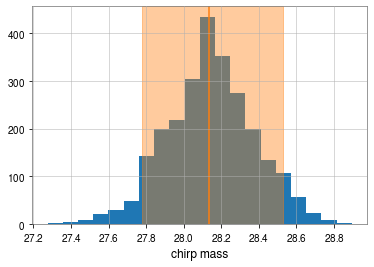

In [19]:
fig, ax = plt.subplots()
ax.hist(result_short.posterior["chirp_mass"], bins=20)
ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.4)
ax.axvline(median, color='C1')
ax.set_xlabel("chirp mass")
plt.show()

The result object also has in-built methods to make nice plots such as corner plots. You can add the priors if you are only plotting parameter which you sampled in, e.g.

/home/hemantakumar.phurailatpam/anaconda3/envs/bilby/lib/python3.6/site-packages/gwpy/plot/axes.py:75: UserWarning: Attempting to set identical left == right == 1126259642.413 results in singular transformations; automatically expanding.
  return func(self, **kw)
/home/hemantakumar.phurailatpam/anaconda3/envs/bilby/lib/python3.6/site-packages/corner/corner.py:809: UserWarning: Attempting to set identical bottom == top == 1126259642.413 results in singular transformations; automatically expanding.
  ax.set_ylim(range[1])
/home/hemantakumar.phurailatpam/anaconda3/envs/bilby/lib/python3.6/site-packages/corner/corner.py:809: UserWarning: Attempting to set identical bottom == top == 1126259642.413 results in singular transformations; automatically expanding.
  ax.set_ylim(range[1])


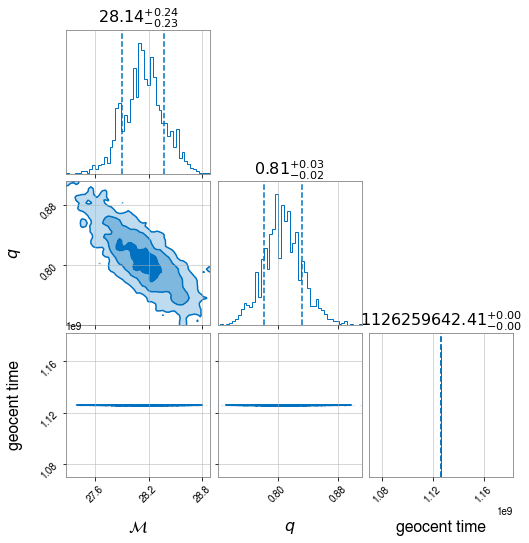

In [20]:
result_short.plot_corner(parameters=["chirp_mass", "mass_ratio", "geocent_time"], prior=True)

You can also plot lines indicating specific points. Here, we add the values recorded on [GWOSC](https://www.gw-openscience.org/events/GW150914/). Notably, these fall outside the bulk of the posterior uncertainty here. This is because we limited our prior - if instead we ran the full analysis these agree nicely.

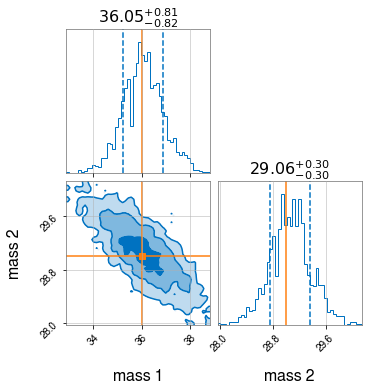

In [21]:
parameters = dict(mass_1=36, mass_2=29)
result_short.plot_corner(parameters)

Earlier we discussed the "correlation" - in this plot we start to see the correlation between $m_1$ and $m_2$.

### Meta data
The result object also stores meta data, like the priors

In [22]:
result_short.priors

{'chirp_mass': Uniform(minimum=27.0, maximum=32.5, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None),
 'mass_ratio': Uniform(minimum=0.5, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None),
 'a_1': DeltaFunction(peak=0.4, name=None, latex_label=None, unit=None),
 'a_2': DeltaFunction(peak=0.3, name=None, latex_label=None, unit=None),
 'tilt_1': DeltaFunction(peak=0.5, name=None, latex_label=None, unit=None),
 'tilt_2': DeltaFunction(peak=1.0, name=None, latex_label=None, unit=None),
 'phi_12': DeltaFunction(peak=1.7, name=None, latex_label=None, unit=None),
 'phi_jl': DeltaFunction(peak=0.3, name=None, latex_label=None, unit=None),
 'psi': DeltaFunction(peak=2.659, name=None, latex_label=None, unit=None),
 'ra': DeltaFunction(peak=1.375, name=None, latex_label=None, unit=None),
 'dec': DeltaFunction(peak=-1.2108, name=None, latex_label=None, unit=None),
 'luminosity_distance': DeltaFunction(peak=4000.0, name=None, latex_label=None, unit=

and details of the analysis itself:

In [23]:
result_short.sampler_kwargs["nlive"]

500

Finally, we can also get out the Bayes factor for the signal vs. Gaussian noise:

In [24]:
print("ln Bayes factor = {} +/- {}".format(
    result_short.log_bayes_factor, result_short.log_evidence_err))

ln Bayes factor = 29.102763580914655 +/- 0.125169245578615


## Challenge questions

* Rerun the analysis with a different samler. *Hint: [see the docs](https://lscsoft.docs.ligo.org/bilby/samplers.html#switching-between-samplers)*. This may require you to install a new sampler!
* Rerun the analysis with time marginalization. This will require you to change the prior to a uniform prior centered on the simulation value.